Bella is a translational neuroscientist who evaluates the changes to cognitive processes in a mouse disease model for schizophrenia. She noted that PV gene expression is reduced in this model and wonders what possible effects there could be on the mesoconnectome and the resulting brain activity (modeled through the virtual mouse brain on the HBP platform). She uses the weight matrix of the latest predictive model on a gene expression vector that includes a reduction in PV expression and predicts the new connectivity patterns and sends them to the virtual mouse brain, whose output is analyzed through the neural activity tool (NAR).


Initially a series of data structures, files and functions that have to be utilized throughout the analysis have to be stored in the current directory space.    

The cfg.py file is used for updating and importing all useful libraries to be used throughout the analysis.
Moreover, all functions/classes inside cfg.py (find_notebook, NotebookLoader, NotebookFinder) were taken from a tutorial on how to import external jupyter notebooks as modules.  
Documentations about the aforementioned functions and classes can be found in this link:  
https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html  
The code below is responsible for downloading the aforementioned data from the storage space.  

In this step a series of libraries whose classes and functions have to be utilized throughout the analysis,  
are being downloaded from the storage space and imported as modules.

Before the analysis initiation, the gene expression dataset is being pre-processed with the PreProcessing function of the Mesoconnectome Predictor (MesoPred instance of our model).

In [51]:
import os
from subprocess import call
import pickle as pk
from IPython.display import clear_output
current_dir = os.listdir('./')
for path in os.listdir('../25 3 2019/'):
    if os.path.islink(path) is not True and path not in current_dir:
        call(['ln','-s','../25 3 2019/'+ path, path])         
from cfg import *
os.chdir('../CCP_Collab_Backup_2/')
import PrimaryLibrary as PL
imp.reload(PL)
import MorphologyLibrary as MLab
imp.reload(MLab)
import Allen_API_Library as API
imp.reload(API)
MesoPred = PL.MesoconnectomePredictor()

importing Jupyter notebook from Allen_API_Library.ipynb


In this cell, an initialization of an sbaInterface_class instance is being made.
The sbaInterface_class serves as an API for calling the Scalable Brain Composer (SBA)  brain visualization tool. As shown by the steps below, we will use the SBA for a series of visualizations.  
As soon as the initialization is being made, a window will pop-up. On later steps, values will be passed to SBA which will lead to visualizations displayed in the aforementioned window.

In [2]:
# SBA Composer page to load: here it is the -dev version and atlas ABA_v3
sbaHost = 'https://sba-dev.incf.org/composer'
sbaUrl  = sbaHost + '/index.php?template=ABA_v3&scene={"background":"FFFFFF"}' 
sbaInterface = PL.sbaInterface_class(sbaHost,sbaUrl)  

### Data/Parameter Intialization
We load the gene expression dataset that we have used for our predictive analysis (CCP Pipeline).

In [3]:
GeneExp        = h5py.File('G_Exp.hdf5', 'r')['dataset1']
GeneMeta       = pk.load(open('GeneMeta.pkl','r'))
ConDict        = pk.load(open('CreLineDict.pkl','rb'))
clear_output()

Once the MesoPred instance has been initialized, we reduce our gene expression data to a set of structural brain areas that have the finest possible level of description (leaf keys).    

In [4]:
GeneExp_reduced         = np.asarray(GeneExp)[MesoPred.params['leaf_keys'],:]
ConStr_reduced          = np.asarray(ConDict['wild_type']['ConMat'])[MesoPred.params['leaf_keys'],:]

The pre-processing function cleans the dataset from NaN (not a number) values and outliers, performs cubic root transformation to achieve a less skewed distribution, and z-scores the data for faster algorithmic convergence.  

In [5]:
GeneExp_new, gene_scaler,ConStr_new,con_scaler = MesoPred.PreProcessing(GeneExp_reduced, MesoPred.params,ConStr_reduced)
clear_output()

Since we are not interested in training a predictive model but instead testing the data on pre-existing ones, the data are being re-scaled with a scaler object back to their pre-scaled form.

In [6]:
GeneExp_res             = gene_scaler.inverse_transform(GeneExp_new)

### Step 1: Transcriptional Gradients
Transcriptional gradients from the given gene expression data are being initially estimated with the Dictionary learning and sparse coding technique (DLSC) (J. Mairal, F. Bach, J. Ponce, and G. Sapiro. Online dictionary learning for sparse coding. ICML, 2009).  
The estimation is being done in order for Bella to assess the effect that the gene co-expression network of PV has on anatomically distinct structural brain areas.

Since the process takes quite some time, the results have been stored in pickle files and are loaded for our analysis. However, the commented code indicates the way that we call the dictionary learning function.

In [7]:
Gradients, Components, dict_mdl = MesoPred.DictionaryDecomposition(GeneExp_res.T)
Gradients = Gradients.T
Components = Components.T
pk.dump(Gradients,open('Gradients.pkl','wb'))
pk.dump(Components,open('Components.pkl','wb'))
pk.dump(dict_mdl,open('dict_mdl.pkl','wb'))
#Gradients  = pk.load(open('Gradients.pkl','rb'))
#Components = pk.load(open('Components.pkl','rb'))
#dict_mdl   = pk.load(open('dict_mdl.pkl','rb'))

Commencing dictionary decomposition ...
(3318, 200) (200, 428)


/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Atoms : (200, 428)
Code : (3318, 200)
Sparsity: 0.0
Participation: 0.483644859813
Error: 76.76436684536515
Elapsed time: 26.3738699476


### Step 2:  Gradient selection
In this step, Bella can identify the gradient in which the PV gene is most strongly co-expressed for further analysis.

In [8]:
PV_index = [idx for idx,gene in enumerate(MesoPred.params['Gene Acronyms']) if 'Pvalb' in gene][0]
PV_dominated_atom = np.argmax(Components[:,PV_index])
print 'The selected PV-related gradient is: {}.\nThe co-expression energy is: {}'.format(PV_index, np.max(Components[:,PV_index]))

The selected PV-related gradient is: 1317.
The co-expression energy is: 17.7809198579


### Step 3: Gradient visualization  
In this step, the effect of the selected gradient across the mouse brain is being visually inspected with three different approaches:
*  Brain slice visualization with the use of the BrainPlotter tool.
*  3D brain visualization with the use of the Scalable Brain Composer (SBA) tool.
*  Cortical flatmap visualization the use of the BrainPlotter tool.

#### Brain Slice visualization

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


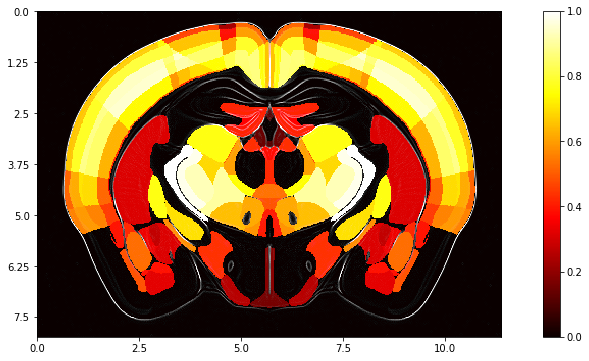

In [9]:
BP_25 = PL.BrainPlotter(resolution = 25)
BP_25.fit(projection = Gradients[:,PV_dominated_atom], 
          chosen_indices = MesoPred.params['remaining_indices'])
BP_25.plot_slice()

#### Call to the SBA tool   
When SBA is being called, a green pop-up window will show up. If the user clicks on "Re-open SBA Composer" the results will be displayed on the window that was opened during the first steps.   
The user can navigate through the various parts of the mouse brain for visual inspection, by utilizing the buttons on the right part of the screen.  
A tutorial for the tool is being provided by clicking at the Readme & FAQ button at the left top of the screen. 

In [10]:
voxel_pv_gradient = BP_25.pd
sbaCommand        = BP_25.Call_SBA(InputData = voxel_pv_gradient, mode = 'nifti')
sbaInterface.send(sbaCommand)
clear_output()

#### Cortical flatmap visualization

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


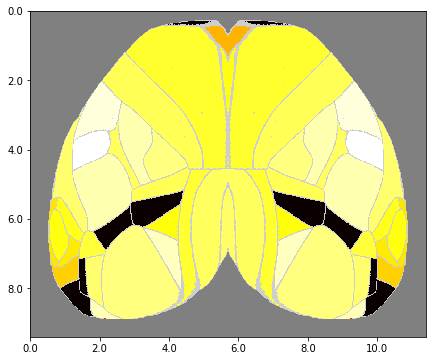

In [11]:
BP_10 = PL.BrainPlotter(resolution = 10)
BP_10.fit(projection = Gradients[:,PV_dominated_atom], 
          chosen_indices = MesoPred.params['remaining_indices'])
BP_10.plot_flatmap()
BP_10 = []
BP_25 = []

### Step 4: Modification of PV related expression
In this step, Bella can modify the expression of PV in a way of simulating the reduced values that she had found in her model.
The relationship between modified PV and the dominant gradient can be shown in two ways:
1.  Expression of PV is being reduced
2.  The gene coefficients corresponding to the dominant gradient are being reduced, and the gene expression is being re-estimated based on the inner product between the new coefficients and the gradients.    


In this analysis we shall focus on the first case

#### Case 1

In [12]:
GeneExp_mod  = GeneExp_res.copy()
GeneExp_mod[:,PV_index] *= 10e-6
modified_gradients = dict_mdl.transform(GeneExp_mod.T)
modified_gradients = dict_mdl.components_.T

#### Case 2

In [13]:
Components_mod  = Components.copy()
Components_mod[PV_dominated_atom,:]*=10e-6
GeneExp_mod2 = np.dot(Gradients,Components_mod)

### Step 5: Modified gradient visualization
Changes on the dominant gradient are being visually inspected as in step #3.

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


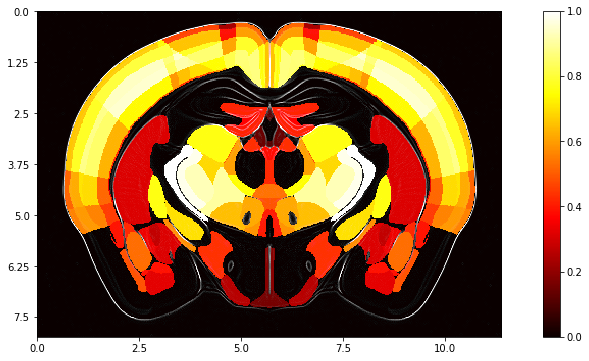

In [14]:
BP_25 = PL.BrainPlotter(resolution = 25)
BP_25.fit(projection     = modified_gradients[:,PV_dominated_atom], 
          chosen_indices = MesoPred.params['remaining_indices'])
BP_25.plot_slice()

In [15]:
voxel_pv_gradient = BP_25.pd
sbaCommand        = BP_25.Call_SBA(InputData = voxel_pv_gradient, mode = 'nifti')
sbaInterface.send(sbaCommand)

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


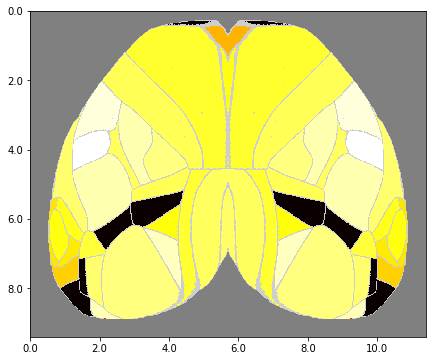

In [16]:
BP_10 = PL.BrainPlotter(resolution = 10)
BP_10.fit(projection = modified_gradients[:,PV_dominated_atom], 
          chosen_indices = MesoPred.params['remaining_indices'])
BP_10.plot_flatmap()

In [17]:
BP_10 = []
BP_25 = []

### Step 6: Predicted Projections

Let's assume that Bella is interested in predicted projection patterns coming from layer 6 corticothalamic cell types.
There are two approaches to it.   
The first approach is to utilze the CCP tool with the PredictProjections function which will predict the desired projection patterns based on altered gene expression patterns tested on the CCP predictive models. The outcome will be a matrix consisting of   target brain areas and a set source brain areas corresponding to injection locations of measured tracing experiments.     
The second approach is to take the output of the first approach and apply a computational modeling approach (GetLayerResolvedArray function) that was developed as part of the Allen Institute's mouse connectivity models toolbox (see more on Overview). The outcome of this approach is a kernel-regression based smoothened connectivity matrix between regionalized source and brain areas irregardless of the actual injection locations, which can simplify latter meta-analytic and visualization proceedures.

Let's start with the first approach. The MesoconnectomePredictor tool is being called for predicting projections between brain areas based on the modified gene expression (PredictProjections function). 

In [53]:
profile_of_interest = 'L6 CT'
ProjectionMat, exportFile, ProjectionDict = MesoPred.PredictProjections(GeneExp_mod, 
                                                                        layer_profile = profile_of_interest)
print ProjectionMat                                                        

                 CP   SSp-bfd  SSp-bfd 2      VISa        PL      VISp  \
TMv        0.003162  0.044062   0.014855  0.011566  0.039255  0.051838   
SSp-m6b    0.050150  0.006213  -0.000497  0.002893  0.094754 -0.017059   
PSV        0.031941  0.030643   0.001762  0.002420  0.057585  0.018386   
SSp-tr6a   0.045120  0.287462   0.004138  0.004145  0.084084  0.111589   
IF         0.009808 -0.010059   0.000992  0.022694  0.044398 -0.001460   
PT        -0.015696  0.151707   0.053604  0.101680  0.087452  0.186954   
SCiw       0.054390  0.152531   0.002799  0.003868  0.018283  0.060532   
IG         0.037675  0.088971   0.034087  0.047518  0.141932  0.074287   
ENTl2      0.043639 -0.009423   0.000962 -0.000052  0.093815  0.006727   
AAA        0.103342  0.047926   0.006361  0.017231  0.083412  0.003809   
SCdg       0.038788  0.132093   0.001378  0.001557  0.021394  0.045682   
IGL        0.088956  0.206371   0.005657  0.017219 -0.014847  0.214547   
ENTl6a     0.012430  0.007055   0.0010

### Step 7: Find a predicted projection of interest   
Let's assume that Bella is interested at a predicted projection pattern from VISpl as a source area.

In [54]:
vispPattern = ProjectionMat.loc[: , "VISpl"]
print vispPattern

TMv          0.045067
SSp-m6b      0.004240
PSV          0.011931
SSp-tr6a     0.001255
IF           0.030925
PT           0.070760
SCiw         0.006041
IG           0.147211
ENTl2       -0.005950
AAA          0.025158
SCdg         0.003922
IGL          0.007465
ENTl6a       0.000316
VISp6a       0.015045
III         -0.003194
GU1          0.147203
VISpm2/3     0.058760
SCdw         0.000210
PRC         -0.002564
ENTl3       -0.005338
ACB          0.088732
IMD          0.022432
AD           0.073142
LT           0.022963
INC         -0.005087
ADP         -0.000322
VISl6a       0.003954
IO           0.049418
PL6a        -0.007392
IP           0.008763
               ...   
PRNc         0.012938
SSp-ll4      0.001069
AMd          0.056494
MDRNd       -0.001829
AId5         0.006815
SSp-m6a      0.001841
AMv          0.044482
IA           0.018487
VISC2/3      0.038203
MDRNv        0.012950
PS           0.007408
SSp-tr5     -0.005275
IAD          0.059657
VISal4       0.008711
IAM       

### Step 8: Visualize the projection  
Cortical flatmap and brain slice visualization for the predicted projection pattern of interest (VISpl).

In [55]:
BP_10_new = PL.BrainPlotter(resolution = 10)
BP_25_new = PL.BrainPlotter(resolution = 25)

BP_10_new.fit(projection = np.asarray(vispPattern), chosen_indices = MesoPred.params['remaining_indices'])
BP_25_new.fit(projection = np.asarray(vispPattern), chosen_indices = MesoPred.params['remaining_indices'])

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


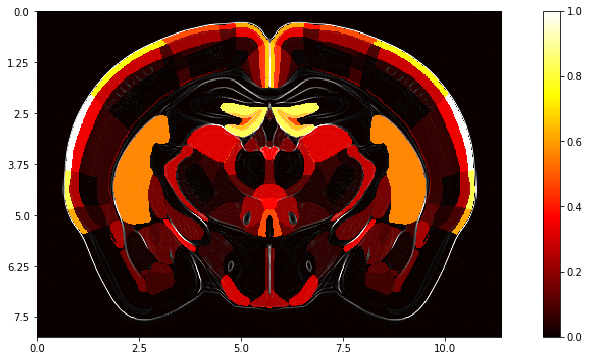

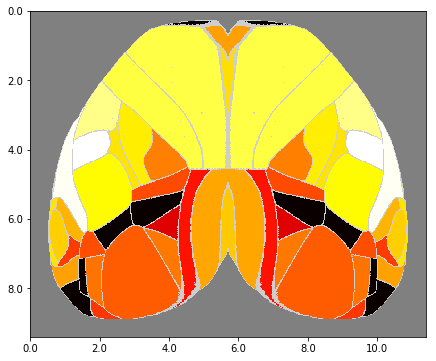

In [56]:
BP_25_new.plot_slice()
BP_10_new.plot_flatmap()

### Step 9: Upload the results back to the collab storage

In [57]:
if os.path.isfile('./' + str(exportFile)) == False:
    client.upload_file(exportFile,os.path.join(collab_path, exportFile))

### Step 10: Alternatively construct a regional 2D connectivity matrix based on the profile of interest (L6 CT)

Let's continue with the second approach as mentioned in step 6

In [58]:
creFilter = [key for key,value in ConDict.items() 
             if value['layer'][0] in profile_of_interest and value['cell-type'][0] in profile_of_interest]
layer_resolved_array, model_meta = MesoPred.GetLayerResolvedArray(mode = 'unionized', 
                                                                  creFilter = creFilter,
                                                                  InputDict = ProjectionDict, 
                                                                  rem_ind = MesoPred.params['remaining_indices'])

Current analyzed cre lines are: L6 CT -> ['Ntsr1-Cre_GN220', 'Syt6-Cre_KI148']


2020-04-01 13:28:23,583 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/299828473?image=data_mask&resolution=100
2020-04-01 13:28:24,098 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/299828473?image=injection_density&resolution=100
2020-04-01 13:28:24,449 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/299828473?image=injection_fraction&resolution=100
2020-04-01 13:28:24,792 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/299828473?image=projection_density&resolution=100
2020-04-01 13:28:26,025 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/292791310?image=data_mask&resolution=100
2020-04-01 13:28:26,527 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 13:28:50,880 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/543679575?image=data_mask&resolution=100
2020-04-01 13:28:51,383 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/543679575?image=injection_density&resolution=100
2020-04-01 13:28:51,729 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/543679575?image=injection_fraction&resolution=100
2020-04-01 13:28:52,081 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/543679575?image=projection_density&resolution=100
2020-04-01 13:28:53,161 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159322514?image=data_mask&resolution=100
2020-04-01 13:28:53,814 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 13:29:17,122 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/544488252?image=data_mask&resolution=100
2020-04-01 13:29:17,776 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/544488252?image=injection_density&resolution=100
2020-04-01 13:29:18,121 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/544488252?image=injection_fraction&resolution=100
2020-04-01 13:29:18,464 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/544488252?image=projection_density&resolution=100
2020-04-01 13:29:19,367 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159554010?image=data_mask&resolution=100
2020-04-01 13:29:20,046 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 13:29:42,838 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297628576?image=data_mask&resolution=100
2020-04-01 13:29:43,497 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297628576?image=injection_density&resolution=100
2020-04-01 13:29:43,849 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297628576?image=injection_fraction&resolution=100
2020-04-01 13:29:44,192 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/297628576?image=projection_density&resolution=100
2020-04-01 13:29:45,406 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/478257959?image=data_mask&resolution=100
2020-04-01 13:29:46,065 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 13:30:10,320 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/182341627?image=data_mask&resolution=100
2020-04-01 13:30:10,824 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/182341627?image=injection_density&resolution=100
2020-04-01 13:30:11,165 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/182341627?image=injection_fraction&resolution=100
2020-04-01 13:30:11,507 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/182341627?image=projection_density&resolution=100
2020-04-01 13:30:12,901 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/156784823?image=data_mask&resolution=100
2020-04-01 13:30:13,585 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 13:30:35,394 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/511817919?image=data_mask&resolution=100
2020-04-01 13:30:35,893 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/511817919?image=injection_density&resolution=100
2020-04-01 13:30:36,241 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/511817919?image=injection_fraction&resolution=100
2020-04-01 13:30:36,594 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/511817919?image=projection_density&resolution=100
2020-04-01 13:30:38,542 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/157909001?image=data_mask&resolution=100
2020-04-01 13:30:39,041 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 13:31:02,880 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/181180790?image=data_mask&resolution=100
2020-04-01 13:31:03,541 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/181180790?image=injection_density&resolution=100
2020-04-01 13:31:03,890 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/181180790?image=injection_fraction&resolution=100
2020-04-01 13:31:04,241 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/181180790?image=projection_density&resolution=100
2020-04-01 13:31:05,614 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/518217838?image=data_mask&resolution=100
2020-04-01 13:31:06,276 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 13:31:30,275 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/495753765?image=data_mask&resolution=100
2020-04-01 13:31:30,800 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/495753765?image=injection_density&resolution=100
2020-04-01 13:31:31,170 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/495753765?image=injection_fraction&resolution=100
2020-04-01 13:31:31,520 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/495753765?image=projection_density&resolution=100
2020-04-01 13:31:32,278 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159330030?image=data_mask&resolution=100
2020-04-01 13:31:32,938 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 13:31:57,725 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/179641666?image=data_mask&resolution=100
2020-04-01 13:31:59,010 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/179641666?image=injection_density&resolution=100
2020-04-01 13:31:59,357 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/179641666?image=injection_fraction&resolution=100
2020-04-01 13:31:59,707 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/179641666?image=projection_density&resolution=100
2020-04-01 13:32:01,086 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/181179335?image=data_mask&resolution=100
2020-04-01 13:32:01,585 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 13:32:25,774 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/553746532?image=data_mask&resolution=100
2020-04-01 13:32:26,276 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/553746532?image=injection_density&resolution=100
2020-04-01 13:32:26,627 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/553746532?image=injection_fraction&resolution=100
2020-04-01 13:32:26,973 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/553746532?image=projection_density&resolution=100
2020-04-01 13:32:28,506 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/156785529?image=data_mask&resolution=100
2020-04-01 13:32:29,168 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 13:32:53,195 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/539738599?image=data_mask&resolution=100
2020-04-01 13:32:53,852 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/539738599?image=injection_density&resolution=100
2020-04-01 13:32:54,197 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/539738599?image=injection_fraction&resolution=100
2020-04-01 13:32:54,541 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/539738599?image=projection_density&resolution=100
2020-04-01 13:32:55,448 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/168096467?image=data_mask&resolution=100
2020-04-01 13:32:56,108 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 13:33:19,943 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/125801033?image=data_mask&resolution=100
2020-04-01 13:33:20,288 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/125801033?image=injection_density&resolution=100
2020-04-01 13:33:20,637 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/125801033?image=injection_fraction&resolution=100
2020-04-01 13:33:20,981 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/125801033?image=projection_density&resolution=100
2020-04-01 13:33:22,823 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/126353451?image=data_mask&resolution=100
2020-04-01 13:33:23,325 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 13:33:47,652 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/601268292?image=data_mask&resolution=100
2020-04-01 13:33:48,316 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/601268292?image=injection_density&resolution=100
2020-04-01 13:33:48,665 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/601268292?image=injection_fraction&resolution=100
2020-04-01 13:33:49,014 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/601268292?image=projection_density&resolution=100
2020-04-01 13:33:50,391 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/287037604?image=data_mask&resolution=100
2020-04-01 13:33:51,048 allensdk.api.api.retrieve_file_over_http INFO

2020-04-01 13:34:14,730 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/299820770?image=data_mask&resolution=100
2020-04-01 13:34:15,389 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/299820770?image=injection_density&resolution=100
2020-04-01 13:34:15,734 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/299820770?image=injection_fraction&resolution=100
2020-04-01 13:34:16,090 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/299820770?image=projection_density&resolution=100
2020-04-01 13:34:17,242 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/168097187?image=data_mask&resolution=100
2020-04-01 13:34:17,747 allensdk.api.api.retrieve_file_over_http INFO

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Proj

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Proj

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Proj

In [59]:
print pd.DataFrame(layer_resolved_array[0,:,:], index = model_meta['target id'], columns = model_meta['source id'])

               TMv   SSp-m6b        IC       PSV  SSp-tr6a      SCig  \
TMv       0.063182  0.063265  0.063262  0.063184  0.063327  0.063276   
SSp-m6b   0.024040  0.024417  0.023598  0.023630  0.024144  0.023793   
int       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
PSV       0.047698  0.048013  0.047631  0.047512  0.047995  0.047745   
SSp-tr6a  0.049599  0.049676  0.049020  0.049260  0.049283  0.049140   
SCig      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
IF        0.022611  0.022669  0.022878  0.022722  0.022858  0.022853   
PT        0.096869  0.096739  0.098204  0.097627  0.097649  0.097944   
SCiw      0.062224  0.062327  0.061641  0.061871  0.061933  0.061769   
IG        0.100529  0.100458  0.100748  0.100677  0.100603  0.100689   
ENTl2     0.021582  0.021622  0.022252  0.021913  0.022087  0.022156   
AAA       0.031744  0.031877  0.031988  0.031807  0.032057  0.031992   
SCdg      0.052699  0.052783  0.052251  0.052426  0.052481  0.05